Saving bat-1_frame1.png to bat-1_frame1.png
✅ Contours detected: 2
Hu Moments: [ 3.20644731e-01  3.96307447e-02  1.97988181e-02  1.31586515e-03
 -2.84583096e-06 -1.51583740e-04  6.08369197e-06]


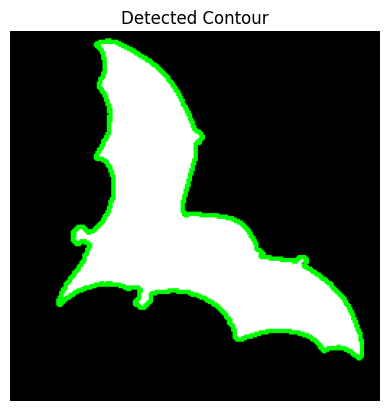

In [1]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload the image
uploaded = files.upload()

# Load grayscale image
image = cv2.imread(r'/content/bat-1_frame1.png', cv2.IMREAD_GRAYSCALE)

# Check if image is loaded
if image is None:
    print("❌ Error: Could not load the image. Check the file path!")
    exit()

# Find contours
contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Print the number of contours found
if len(contours) > 0:
    print(f"✅ Contours detected: {len(contours)}")
else:
    print("❌ No contours detected! The object might be disconnected, too small, or filled with noise.")

# Sort contours by area (largest first)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Select the largest contour
largest_contour = contours[0]

# Get bounding box of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Compute Hu moments
moments = cv2.moments(largest_contour)
hu_moments = cv2.HuMoments(moments).flatten()

print("Hu Moments:", hu_moments)

# Draw the contour on the original image
image_contour = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color
cv2.drawContours(image_contour, [largest_contour], -1, (0, 255, 0), 2)  # Green contour

# Display image
plt.imshow(image_contour)
plt.title("Detected Contour")
plt.axis('off')  # Hide axis
plt.show()

In [2]:
from google.colab import files
import zipfile
import os

# Upload ZIP file manually
uploaded = files.upload()

# Extract the ZIP file
zip_path = "Preprocesseddata.zip"  # Change if your zip name is different
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract to /content/

# Check if files are extracted
print("✅ Files extracted. Folder contains:", os.listdir("/content/Preprocesseddata"))

Saving Preprocesseddata.zip to Preprocesseddata.zip
✅ Files extracted. Folder contains: ['key-14.png', 'jar-15.png', 'shoe-19.png', 'classic13.png', 'bat-14_frame1.png', 'camel-4_frame1.png', 'device7_8.png', 'shoe-1.png', 'classic12.png', 'Misk-10.png', 'shoe-3.png', 'fly-2.png', 'device3_14.png', 'Bone-5_frame1.png', 'shoe-7.png', 'fork-9.png', 'HCircle-10.png', 'pocket-11.png', 'cellular_phone-20_frame1.png', 'elephant11.png', 'Bone-9_frame1.png', 'device3_11.png', 'fly-14.png', 'jar-4.png', 'camel-16_frame1.png', 'camel-17_frame1.png', 'classic11.png', 'brick-18_frame1.png', 'device3_8.png', 'brick-08_frame1.png', 'brick-01_frame1.png', 'Glas-16.png', 'classic8.png', 'pocket-6.png', 'pocket-15.png', 'HCircle-15.png', 'key-1.png', 'HCircle-6.png', 'bat-19_frame1.png', 'fork-19.png', 'new_deer15.png', 'Misk-16.png', 'device7_13.png', 'key-13.png', 'new_deer17.png', 'device7_2.png', 'device3_20.png', 'device3_10.png', 'brick-05_frame1.png', 'Misk-6.png', 'device3_12.png', 'cellular_ph

In [44]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

dataset_path = "/content/Preprocesseddata"  # Change this if necessary

# Function to extract Hu Moments
def extract_hu_moments(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None

    # Apply binary thresholding
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Calculate moments
    moments = cv2.moments(binary)
    hu_moments = cv2.HuMoments(moments)

    # Handle zero values to avoid log(0) issues
    hu_moments = np.where(hu_moments == 0, 1e-10, hu_moments)

    # Apply log transformation safely
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    return hu_moments.flatten()

# List to store features and filenames
features = []
image_names = []

# Extract Hu Moments from all images in the dataset
for filename in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, filename)
    hu_moments = extract_hu_moments(image_path)
    if hu_moments is not None:
        features.append(hu_moments)
        image_names.append(filename)

print(f"Extracted Hu Moments from {len(features)} images.")

# Convert to DataFrame
columns = [f"Hu_{i+1}" for i in range(7)]  # Hu Moments have 7 values
df_hu_moments = pd.DataFrame(features, columns=columns)

# Add image names
df_hu_moments.insert(0, "Image_Name", image_names)

# Save as CSV file
csv_path = "Hu_Moments_Features.csv"
df_hu_moments.to_csv(csv_path, index=False)
print(f"Feature extraction complete! CSV saved at: {csv_path}")

# Normalize features using Z-score normalization
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df_hu_moments.iloc[:, 1:])  # Exclude image names

# Convert normalized features into a DataFrame
df_normalized = pd.DataFrame(normalized_features, columns=[f"Hu_{i+1}" for i in range(normalized_features.shape[1])])
df_normalized.insert(0, "Image_Name", image_names)  # Add image names back

# Save normalized features to a CSV file
normalized_csv_path = "Normalized_Hu_Moments_Features.csv"
df_normalized.to_csv(normalized_csv_path, index=False)
print(f"Normalized features saved at: {normalized_csv_path}")

# Function to retrieve similar images
def retrieve_similar_images(query_image_path, top_n=30):
    # Extract Hu Moments for the query image
    query_features = extract_hu_moments(query_image_path)

    if query_features is None:
        print("Error: Could not extract features from query image.")
        return []

    # Normalize the query features using the same scaler
    query_features = scaler.transform([query_features])

    # Compute Euclidean distances between query and stored features
    distances = [euclidean(query_features.flatten(), stored) for stored in normalized_features]

    # Sort the distances in ascending order
    sorted_indices = np.argsort(distances)

    # Retrieve the top N most similar images
    top_images = [(image_names[i], distances[i]) for i in sorted_indices[:top_n]]

    return top_images

# Path to the query image
query_image_path = "bat-1_frame1.png"  # Update this to your actual query image path

# Retrieve top 30 most similar images
similar_images = retrieve_similar_images(query_image_path)

# Display results
print("Top 30 Most Similar Images:")
for rank, (img_name, dist) in enumerate(similar_images, 1):
    print(f"{rank}. {img_name} - Distance: {dist:.4f}")




Extracted Hu Moments from 400 images.
Feature extraction complete! CSV saved at: Hu_Moments_Features.csv
Normalized features saved at: Normalized_Hu_Moments_Features.csv
Top 30 Most Similar Images:
1. bat-1_frame1.png - Distance: 0.0000
2. bat-9_frame1.png - Distance: 0.1170
3. bat-13_frame1.png - Distance: 0.2285
4. bat-15_frame1.png - Distance: 0.2881
5. new_deer15.png - Distance: 0.3727
6. camel-2_frame1.png - Distance: 1.3568
7. fly-16.png - Distance: 1.4159
8. classic16.png - Distance: 1.4207
9. camel-8_frame1.png - Distance: 1.5593
10. fly-2.png - Distance: 1.6500
11. bat-5_frame1.png - Distance: 1.7028
12. bat-14_frame1.png - Distance: 1.7504
13. bat-6_frame1.png - Distance: 1.7699
14. camel-1_frame1.png - Distance: 1.8001
15. Misk-19.png - Distance: 1.8135
16. new_deer16.png - Distance: 1.8623
17. pocket-14.png - Distance: 1.8829
18. bat-17_frame1.png - Distance: 1.8994
19. bat-16_frame1.png - Distance: 1.8994
20. fly-1.png - Distance: 1.9030
21. Misk-12.png - Distance: 1.9143


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [46]:
import os
import cv2
import numpy as np
import pandas as pd

# Load your dataset features (Make sure this file has image names and features)
df = pd.read_csv("Normalized_Hu_Moments_Features.csv")  # Adjust filename if needed

# Extract Image Names and Features
image_names = df.iloc[:, 0].values  # First column has image names
dataset_features = df.iloc[:, 1:].values  # Remaining columns have features

# Example mapping of images to their classes
relevant_images_map = {
    "bat-1_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png", "bat-20_frame1.png"],
    "bat-2_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png", "bat-20_frame1.png"],
    "bat-3_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-4_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-5_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-6_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-7_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-8_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-9_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-10_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-11_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-12_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-13_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-14_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-15_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-16_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-17_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-18_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-19_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "bat-20_frame1.png": ["bat-1_frame1.png", "bat-2_frame1.png", "bat-3_frame1.png", "bat-4_frame1.png", "bat-5_frame1.png", "bat-6_frame1.png", "bat-7_frame1.png", "bat-8_frame1.png", "bat-9_frame1.png", "bat-10_frame1.png", "bat-11_frame1.png", "bat-12_frame1.png", "bat-13_frame1.png", "bat-14_frame1.png", "bat-15_frame1.png", "bat-16_frame1.png", "bat-17_frame1.png", "bat-18_frame1.png", "bat-19_frame1.png" , "bat-20_frame1.png" ],
        "Bone-1_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-2_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-3_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-4_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-5_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-6_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-7_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-8_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-9_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-10_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-11_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-12_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-13_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-14_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-15_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-16_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-17_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-18_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-19_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "Bone-20_frame1.png": ["Bone-1_frame1.png", "Bone-2_frame1.png", "Bone-3_frame1.png", "Bone-4_frame1.png", "Bone-5_frame1.png", "Bone-6_frame1.png", "Bone-7_frame1.png", "Bone-8_frame1.png", "Bone-9_frame1.png", "Bone-10_frame1.png", "Bone-11_frame1.png","Bone-12_frame1.png","Bone-13_frame1.png","Bone-14_frame1.png","Bone-15_frame1.png","Bone-16_frame1.png","Bone-17_frame1.png","Bone-18_frame1.png","Bone-19_frame1.png","Bone-20_frame1.png"],
        "brick-01_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-02_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-03_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-04_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-05_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-06_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-07_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-08_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-09_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-10_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-11_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-12_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-13_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-14_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-15_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-16_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-17_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-18_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-19_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "brick-20_frame1.png": ["brick-01_frame1.png", "brick-02_frame1.png", "brick-03_frame1.png", "brick-04_frame1.png", "brick-05_frame1.png", "brick-06_frame1.png", "brick-07_frame1.png", "brick-08_frame1.png", "brick-09_frame1.png", "brick-10_frame1.png", "brick-11_frame1.png","brick-12_frame1.png", "brick-13_frame1.png", "brick-14_frame1.png", "brick-15_frame1.png", "brick-16_frame1.png", "brick-17_frame1.png","brick-18_frame1.png", "brick-19_frame1.png","brick-20_frame1.png"],
        "camel-1_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-2_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-3_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-4_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-5_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-6_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-7_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-8_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-9_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-10_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-11_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-12_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-13_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-14_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-15_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-16_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-17_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-18_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-19_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "camel-20_frame1.png": ["camel-1_frame1.png", "camel-2_frame1.png", "camel-3_frame1.png", "camel-4_frame1.png", "camel-5_frame1.png", "camel-6_frame1.png", "camel-7_frame1.png", "camel-8_frame1.png", "camel-9_frame1.png", "camel-10_frame1.png", "camel-11_frame1.png","camel-12_frame.png", "camel-13_frame1.png", "camel-14_frame1.png", "camel-15_frame1.png","camel-16_frame1.png","camel-17_frame1.png","camel-18_frame1.png","camel-19_frame1.png","camel-20_frame1.png"],
        "cellular_phone-1_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-2_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-3_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-4_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-5_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-6_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-7_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-8_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-9_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-10_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-11_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-12_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-13_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-14_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-15_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-16_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-17_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-18_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-19_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "cellular_phone-20_frame1.png": ["cellular_phone-1_frame1.png", "cellular_phone-2_frame1.png","cellular_phone-3_frame1.png","cellular_phone-4_frame1.png","cellular_phone-5_frame1.png","cellular_phone-6_frame1.png","cellular_phone-7_frame1.png","cellular_phone-8_frame1.png","cellular_phone-9_frame1.png","cellular_phone-10_frame1.png","cellular_phone-11_frame1.png","cellular_phone-12_frame1.png","cellular_phone-13_frame1.png","cellular_phone-14_frame1.png","cellular_phone-15_frame1.png","cellular_phone-1_frame16.png","cellular_phone-17_frame1.png","cellular_phone-18_frame1.png","cellular_phone-19_frame1.png","cellular_phone-20_frame1.png"],
        "classic1.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic2.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic3.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic4.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic5.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic6.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic7.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic8.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic9.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic10.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic11.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic12.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic13.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic14.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic15.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic16.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic17.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic18.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic19.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "classic20.png": {"classic1.png", "classic2.png","classic3.png", "classic4.png","classic5.png","classic6.png","classic7.png","classic8.png","classic9.png", "classic10.png", "classic11.png","classic12.png","classic13.png","classic14.png","classic15.png","classic16.png","classic17.png","classic18.png","classic19.png","classic20.png"},
        "device3_1.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_2.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_3.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_4.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_5.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_6.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_7.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_8.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_9.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_10.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_11.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_12.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_13.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_14.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_15.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_16.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_17.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_18.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_19.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device3_20.png": ["device3_1.png", "device3_2.png", "device3_3.png", "device3_4.png", "device3_5.png", "device3_6.png", "device3_7.png", "device3_8.png", "device3_9.png", "device3_10.png", "device3_11.png","device3_12.png", "device3_13.png", "device3_14.png", "device3_15.png", "device3_16.png", "device3_17.png", "device3_18.png", "device3_19.png", "device3_20.png"],
        "device7_1.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_2.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_3.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_4.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_5.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_6.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_7.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_8.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_9.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_10.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_11.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_12.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_13.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_14.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_15.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_16.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_17.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_18.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_19.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "device7_20.png": ["device7_1.png", "device7_2.png","device7_3.png", "device7_4.png", "device7_5.png", "device7_6.png", "device7_7.png", "device7_8.png", "device7_9.png", "device7_10.png", "device7_11.png", "device7_12.png","device7_13.png", "device7_14.png", "device7_15.png", "device7_16.png","device7_17.png","device7_18.png","device7_19.png","device7_20.png"],
        "elephant1.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant2.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant3.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant4.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant5.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant6.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant7_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant8_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant9_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant10.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant11.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant12.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant13_new.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant14.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant15.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant16.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant17.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant18.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant19.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "elephant20.png":["elephant1.png", "elephant2.png", "elephant3.png", "elephant4.png", "elephant5.png", "elephant6.png", "elephant7_new.png", "elephant8_new.png", "elephant9_new.png", "elephant10_new.png", "elephant11.png", "elephant12.png", "elephant13_new.png", "elephant14.png", "elephant15.png", "elephant16.png", "elephant17.png", "elephant18.png", "elephant19.png", "elephant20.png" ],
        "fly-1.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-2.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-3.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-4.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-5.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-6.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-7.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-8.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-9.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-10.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-11.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-12.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-13.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-14.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-15.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-16.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-17.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-18.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-19.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fly-20.png":["fly-1.png", "fly-2.png", "fly-3.png","fly-4.png","fly-5.png", "fly-6.png", "fly-7.png","fly-8.png","fly-9.png","fly-10.png","fly-11.png","fly-12.png","fly-13.png","fly-14.png","fly-15.png","fly-16.png","fly-17.png","fly-18.png","fly-19.png","fly-20.png" ],
        "fork-1.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-2.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-3.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-4.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-5.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-6.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-7.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-8.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-9.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-10.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-11.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-12.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-13.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-14.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-15.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-16.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-17.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-18.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-19.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "fork-20.png":["fork-1.png", "fork-2.png","fork-3.png","fork-4.png","fork-5.png","fork-6.png","fork-7.png","fork-8.png","fork-9.png","fork-10.png","fork-11.png","fork-12.png","fork-13.png","fork-14.png","fork-15.png","fork-16.png","fork-17.png","fork-18.png","fork-19.png","fork-20.png"],
        "Glas-1.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-2.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-3.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-4.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-5.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-6.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-7.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-8.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-9.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-10.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-11.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-12.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-13.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-14.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-15.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-16.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-17.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-18.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-19.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "Glas-20.png": ["Glas-1.png", "Glas-2.png", "Glas-3.png", "Glas-4.png", "Glas-5.png", "Glas-6.png", "Glas-7.png", "Glas-8.png", "Glas-9.png", "Glas-10.png", "Glas-11.png", "Glas-12.png", "Glas-13.png", "Glas-14.png", "Glas-15.png", "Glas-16.png", "Glas-17.png", "Glas-18.png", "Glas-19.png", "Glas-20.png" ],
        "HCircle-1.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-2.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-3.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-4.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-5.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-6.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-7.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-8.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-9.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-10.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-11.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-12.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-13.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-14.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-15.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-16.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-17.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-18.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-19.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "HCircle-20.png": ["HCircle-1.png", "HCircle-2.png", "HCircle-3.png", "HCircle-4.png", "HCircle-5.png", "HCircle-6.png", "HCircle-7.png", "HCircle-8.png", "HCircle-9.png", "HCircle-10.png", "HCircle-11.png", "HCircle-12.png", "HCircle-13.png", "HCircle-14.png", "HCircle-15.png", "HCircle-16.png", "HCircle-17.png", "HCircle-18.png", "HCircle-19.png", "HCircle-20.png" ],
        "jar-1.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-2.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-3.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-4.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-5.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-6.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-7.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-8.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-9.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-10.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-11.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-12.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-13.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-14.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-15.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-16.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-17.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-18.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-19.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "jar-20.png": ["jar-1.png", "jar-2.png", "jar-3.png", "jar-4.png", "jar-5.png", "jar-6.png", "jar-7.png", "jar-8.png", "jar-9.png", "jar-10.png", "jar-11.png", "jar-12.png", "jar-13.png", "jar-14.png", "jar-15.png", "jar-16.png", "jar-17.png", "jar-18.png", "jar-19.png", "jar-20.png" ],
        "key-1.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-2.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-3.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-4.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-5.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-6.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-7.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-8.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-9.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-10.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-11.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-12.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-13.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-14.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-15.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-16.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-17.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-18.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-19.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "key-20.png": ["key-1.png", "key-2.png", "key-3.png", "key-4.png", "key-5.png", "key-6.png", "key-7.png", "key-8.png", "key-9.png", "key-10.png", "key-11.png", "key-12.png", "key-13.png", "key-14.png", "key-15.png", "key-16.png", "key-17.png", "key-18.png", "key-19.png", "key-20.png" ],
        "Misk-1.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-2.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-3.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-4.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-5.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-6.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-7.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-8.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-9.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-10.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-11.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-12.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-13.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-14.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-15.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-16.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-17.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-18.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-19.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "Misk-20.png": ["Misk-1.png", "Misk-2.png", "Misk-3.png", "Misk-4.png", "Misk-5.png", "Misk-6.png", "Misk-7.png", "Misk-8.png", "Misk-9.png", "Misk-10.png", "Misk-11.png", "Misk-12.png", "Misk-13.png", "Misk-14.png", "Misk-15.png", "Misk-16.png", "Misk-17.png", "Misk-18.png", "Misk-19.png", "Misk-20.png" ],
        "new_deer1.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer2.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer3.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer4.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer5.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer6.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer7.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer8.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer9.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer10.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer11.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer12.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer13.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer14.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer15.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer16.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer17.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer18.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer19.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "new_deer20.png": ["new_deer1.png", "new_deer2.png", "new_deer3.png", "new_deer4.png", "new_deer5.png", "new_deer6.png", "new_deer7.png", "new_deer8.png", "new_deer9.png", "new_deer10.png", "new_deer11.png", "new_deer12.png", "new_deer13.png", "new_deer14.png", "new_deer15.png", "new_deer16.png", "new_deer17.png", "new_deer18.png", "new_deer19.png", "new_deer20.png" ],
        "pocket-1.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-2.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-3.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-4.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-5.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-6.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-7.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-8.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-9.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-10.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-11.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-12.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-13.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-14.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-15.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-16.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-17.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-18.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-19.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "pocket-20.png": {"pocket-1.png", "pocket-2.png", "pocket-3.png", "pocket-4.png", "pocket-5.png", "pocket-6.png", "pocket-7.png", "pocket-8.png", "pocket-9.png", "pocket-10.png", "pocket-11.png", "pocket-12.png", "pocket-13.png", "pocket-14.png", "pocket-15.png", "pocket-16.png", "pocket-17.png", "pocket-18.png", "pocket-19.png", "pocket-20.png"  },
        "shoe-1.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-2.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-3.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-4.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-5.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-6.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-7.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-8.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-9.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-10.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-11.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-12.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-13.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-14.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-15.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-16.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-17.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-18.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-19.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "shoe-20.png": ["shoe-1.png", "shoe-2.png", "shoe-3.png", "shoe-4.png", "shoe-5.png", "shoe-6.png", "shoe-7.png", "shoe-8.png", "shoe-9.png", "shoe-10.png", "shoe-11.png", "shoe-12.png", "shoe-13.png", "shoe-14.png", "shoe-15.png", "shoe-16.png", "shoe-17.png", "shoe-18.png", "shoe-19.png", "shoe-20.png" ],
        "teddy-1.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-2.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-3.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-4.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-5.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-6.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-7.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-8.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-9.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-10.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-11.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-12.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-13.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-14.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-15.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-16.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-17.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-18.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-19.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],
        "teddy-20.png": ["teddy-1.png", "teddy-2.png", "teddy-3.png", "teddy-4.png", "teddy-5.png", "teddy-6.png", "teddy-7.png", "teddy-8.png", "teddy-9.png", "teddy-10.png", "teddy-11.png", "teddy-12.png", "teddy-13.png", "teddy-14.png", "teddy-15.png", "teddy-16.png", "teddy-17.png", "teddy-18.png", "teddy-19.png", "teddy-20.png" ],

        # Add other images and their relevant counterparts
        # Complete this mapping based on your dataset
    }



# Function to get relevant images (with safe check)
def get_relevant_images(query_image_name):
    return relevant_images_map.get(query_image_name, [])

# Function to evaluate similarity based on Hu moments
def evaluate_query(query_image_name, query_features, top_n=30):
    y_scores = []  # Stores similarity scores (distances)
    y_true = []    # Stores relevance (1 = relevant, 0 = not relevant)

    # Loop through dataset and compute distances
    for img_name, features in zip(image_names, dataset_features):
        distance = np.linalg.norm(query_features - features)  # Euclidean distance
        y_scores.append(distance)

        # Define Relevant Images using manual mapping
        relevant_images = get_relevant_images(query_image_name)

        # Check for valid relevant images
        if relevant_images is None:
            relevant_images = []

        y_true.append(1 if img_name in relevant_images else 0)  # Mark as relevant or not

    # Convert lists to NumPy arrays
    y_scores = np.array(y_scores)
    y_true = np.array(y_true)

    # Sort images by similarity (lower distances are better)
    sorted_indices = np.argsort(y_scores)  # Get sorted indices
    y_scores = y_scores[sorted_indices]  # Sort distances
    y_true = y_true[sorted_indices]  # Sort relevance accordingly

    # Select Top-N retrieved images
    y_scores = y_scores[:top_n]
    y_true = y_true[:top_n]

    return y_true, y_scores

# Loop through all images in the dataset (Use each image as a query)
for query_index in range(len(image_names)):
    query_image_name = image_names[query_index]  # Query image name
    query_features = dataset_features[query_index]  # Query features

    # Get `y_true` and `y_scores` for this query
    y_true, y_scores = evaluate_query(query_image_name, query_features)

    # Optionally print or log the results
    print(f"Query Image: {query_image_name}")
    print("Relevant: ", y_true)
    print("Scores: ", y_scores)
    print("-" * 30)


Query Image: key-14.png
Relevant:  [1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Scores:  [0.         0.08904704 0.08923567 0.23687849 0.25405332 0.28174163
 0.30651353 0.34591675 0.35861332 0.4288725  0.44722631 0.58698431
 0.65441981 0.67339341 0.69083515 0.70676146 0.70934962 0.719813
 0.74308203 0.74661883 0.74977896 0.75629386 0.76819616 0.77897414
 0.7963175  0.80613884 0.81264684 0.85611497 0.86364777 0.90964484]
------------------------------
Query Image: jar-15.png
Relevant:  [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0]
Scores:  [0.00000000e+00 6.10594907e-14 2.25308115e-01 2.25308115e-01
 3.26442181e-01 3.44430081e-01 4.16393046e-01 4.53375959e-01
 4.92224047e-01 5.24204703e-01 5.28339921e-01 5.60403183e-01
 5.80559071e-01 5.92867185e-01 5.93170463e-01 5.97343637e-01
 6.19356617e-01 6.50155983e-01 6.50155983e-01 7.62718233e-01
 7.74928057e-01 7.83910102e-01 8.25176161e-01 8.34595886e-01
 8.54105161e-01 8.54105161e-01 8.59291116e-01 8.60504246e

In [48]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

# Assuming df_normalized is already created and normalized features are extracted
image_names = df_normalized["Image_Name"].values
dataset_features = df_normalized.iloc[:, 1:].values  # Exclude image names

# Function to get relevant images (with safe check)
def get_relevant_images(query_image_name):
    return relevant_images_map.get(query_image_name, [])

# Function to evaluate similarity based on Hu moments
def evaluate_query(query_image_name, query_features, top_n=30):
    y_scores = []  # Stores similarity scores (distances)
    y_true = []    # Stores relevance (1 = relevant, 0 = not relevant)

    # Loop through dataset and compute distances
    for img_name, features in zip(image_names, dataset_features):
        distance = np.linalg.norm(query_features - features)  # Euclidean distance
        y_scores.append(distance)

        # Define Relevant Images using manual mapping
        relevant_images = get_relevant_images(query_image_name)
        y_true.append(1 if img_name in relevant_images else 0)  # Mark as relevant or not

    # Convert lists to NumPy arrays
    y_scores = np.array(y_scores)
    y_true = np.array(y_true)

    # Sort images by similarity (lower distances are better)
    sorted_indices = np.argsort(y_scores)  # Get sorted indices
    y_scores = y_scores[sorted_indices]  # Sort distances
    y_true = y_true[sorted_indices]  # Sort relevance accordingly

    # Select Top-N retrieved images
    y_scores = y_scores[:top_n]
    y_true = y_true[:top_n]

    return y_true, y_scores

# Initialize lists to store precision, recall, and AUC values
all_precisions = []
all_recalls = []
all_aucs = []

# Loop through all images in the dataset (Use each image as a query)
for query_index in range(len(image_names)):
    query_image_name = image_names[query_index]  # Query image name
    query_features = dataset_features[query_index]  # Query features

    # Get y_true and y_scores for this query
    y_true, y_scores = evaluate_query(query_image_name, query_features)

    # Check if y_true has at least one positive sample (relevant image)
    if np.any(y_true):  # There are relevant images
        # Compute precision-recall curve
        precisions, recalls, _ = precision_recall_curve(y_true, -y_scores)  # Invert scores for sklearn

        # Compute AUC for PR curve
        pr_auc = auc(recalls, precisions)

        # Compute mean precision and mean recall
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)

        # Store results
        all_precisions.append(mean_precision)
        all_recalls.append(mean_recall)
        all_aucs.append(pr_auc)

        print(f"Query {query_index+1}/{len(image_names)} → Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, AUC: {pr_auc:.4f}")
    else:
        print(f"Query {query_index+1}/{len(image_names)} has no relevant images, skipping...")

# Compute Overall Average Precision and Recall
avg_precision = np.mean(all_precisions)
avg_recall = np.mean(all_recalls)

print(f"\n✅ Average Precision: {avg_precision:.4f}")
print(f"✅ Average Recall: {avg_recall:.4f}")



Query 1/400 → Precision: 0.7112, Recall: 0.7859, AUC: 0.9436
Query 2/400 → Precision: 0.4548, Recall: 0.6048, AUC: 0.6390
Query 3/400 → Precision: 0.3275, Recall: 0.9247, AUC: 0.9028
Query 4/400 → Precision: 0.5018, Recall: 0.7788, AUC: 0.7758
Query 5/400 → Precision: 0.6167, Recall: 0.6657, AUC: 0.7694
Query 6/400 → Precision: 0.3907, Recall: 0.7613, AUC: 0.7237
Query 7/400 → Precision: 0.6126, Recall: 0.7065, AUC: 0.8144
Query 8/400 → Precision: 0.6582, Recall: 0.7839, AUC: 0.8919
Query 9/400 → Precision: 0.2431, Recall: 0.4677, AUC: 0.3133
Query 10/400 → Precision: 0.2662, Recall: 0.7097, AUC: 0.7020
Query 11/400 → Precision: 0.4367, Recall: 0.8516, AUC: 0.8718
Query 12/400 → Precision: 0.3275, Recall: 0.9247, AUC: 0.9028
Query 13/400 → Precision: 0.4080, Recall: 0.9194, AUC: 1.0000
Query 14/400 → Precision: 0.5945, Recall: 0.4573, AUC: 0.6270
Query 15/400 → Precision: 0.5365, Recall: 0.7226, AUC: 0.6236
Query 16/400 → Precision: 0.7042, Recall: 0.5907, AUC: 0.7460
Query 17/400 → Pr

Query 1/400 → AUC: 0.9436
Query 2/400 → AUC: 0.6390
Query 3/400 → AUC: 0.9028
Query 4/400 → AUC: 0.7758
Query 5/400 → AUC: 0.7694
Query 6/400 → AUC: 0.7237
Query 7/400 → AUC: 0.8144
Query 8/400 → AUC: 0.8919
Query 9/400 → AUC: 0.3133
Query 10/400 → AUC: 0.7020
Query 11/400 → AUC: 0.8718
Query 12/400 → AUC: 0.9028
Query 13/400 → AUC: 1.0000
Query 14/400 → AUC: 0.6270
Query 15/400 → AUC: 0.6236
Query 16/400 → AUC: 0.7460
Query 17/400 → AUC: 0.8944
Query 18/400 → AUC: 0.3612
Query 19/400 → AUC: 0.9076
Query 20/400 → AUC: 1.0000
Query 21/400 → AUC: 0.8972
Query 22/400 → AUC: 1.0000
Query 23/400 → AUC: 1.0000
Query 24/400 → AUC: 0.7704
Query 25/400 → AUC: 0.7218
Query 26/400 → AUC: 0.4225
Query 27/400 → AUC: 0.5116
Query 28/400 → AUC: 0.9437
Query 29/400 → AUC: 1.0000
Query 30/400 → AUC: 0.6248
Query 31/400 → AUC: 0.7056
Query 32/400 → AUC: 0.7579
Query 33/400 → AUC: 0.6218
Query 34/400 → AUC: 0.5719
Query 35/400 → AUC: 0.3404
Query 36/400 → AUC: 0.9633
Query 37/400 → AUC: 0.9515
Query 38/4

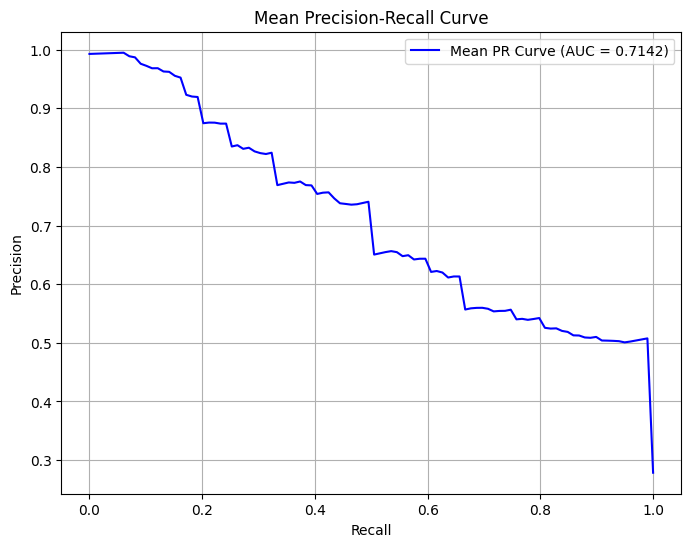

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Initialize lists to store precision, recall, and AUC values
all_precisions = []
all_recalls = []
all_aucs = []
recall_levels = np.linspace(0, 1, 100)  # Fixed recall levels (for averaging curves)

# Initialize array to store interpolated precision values for averaging
interp_precisions = np.zeros_like(recall_levels)

# Loop through all images in the dataset (Use each image as a query)
for query_index in range(len(image_names)):
    query_image_name = image_names[query_index]  # Query image name
    query_features = dataset_features[query_index]  # Query features

    # Get `y_true` and `y_scores` for this query
    y_true, y_scores = evaluate_query(query_image_name, query_features)

    # Check if y_true has at least one positive sample (relevant image)
    if np.any(y_true):  # There are relevant images
        # Compute precision-recall curve
        precisions, recalls, _ = precision_recall_curve(y_true, -y_scores)  # Invert scores for sklearn

        # Compute AUC for PR curve
        pr_auc = auc(recalls, precisions)

        # Store AUC
        all_aucs.append(pr_auc)

        # Interpolate precision values at fixed recall levels for averaging
        interp_prec = np.interp(recall_levels, np.flip(recalls), np.flip(precisions))
        interp_precisions += interp_prec  # Sum up for mean calculation

        print(f"Query {query_index+1}/{len(image_names)} → AUC: {pr_auc:.4f}")

# Compute Mean Precision-Recall Curve
mean_precision = interp_precisions / len(all_aucs)  # Mean precision across queries
mean_auc = np.mean(all_aucs)  # Mean AUC across queries

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_levels, mean_precision, label=f"Mean PR Curve (AUC = {mean_auc:.4f})", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Mean Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()